In [141]:
import numpy as np
from random_data_generator import *
from sequential_estimator import *
import math
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [142]:
def gaussian(mu, var, x):
    sigma = math.sqrt(var)

    a = sigma*math.sqrt(2*math.pi)
    b = -(1/2)*(((x-mu)/sigma)**2)

    return (1/a)*math.exp(b)

In [143]:
def make_design_matrix(x,n):
    A = np.ones((1,n))

    count = 0
    for col in range(0,n):
        A[0,col] = x ** count
        count += 1
    
    return A

In [144]:
make_design_matrix(2,3)

array([[1., 2., 4.]])

In [145]:
def get_newmu_new_var(b,n,a, new_data, first_round: bool, last_mu, last_var):        
    design_matrix = make_design_matrix(new_data[0],n)
    a = 1/a

    if first_round:
        new_mu = inv(np.dot(design_matrix.T,design_matrix)+np.identity(n)*(b/a))
        new_mu = np.dot(new_mu,design_matrix.T)
        new_mu = new_mu*new_data[1]

        new_var = inv(np.dot(a*design_matrix.T,design_matrix)+b*np.identity(n))
        #  posterior_covariance = np.linalg.inv(inv_variance * design.T.dot(design) + precision * np.identity(basis))
    else:
        new_var = inv(last_var) + np.dot(design_matrix.T,design_matrix)*a
        new_var = inv(new_var)

        new_mu = np.dot(inv(last_var),last_mu) + design_matrix.T*new_data[1]*a
        new_mu = np.dot(new_var, new_mu)

    return [new_mu, new_var]



In [146]:
test_data = [[-0.64152, 0.19039],[0.07122, 1.63175],[-0.19330, 0.24507]]

In [147]:
def bayssian_linear(b,n,a,w: list):
    last_mu = 0
    last_var = 0


    count = 1
    data_collector = []
    while True:
        new_data = linear_model_data_generator(n,a,w)
        data_collector.append(new_data)
        # new_data = test_data[count]
        design_matrix = make_design_matrix(new_data[0],n)
        if count==1:
            [new_mu,new_var] = get_newmu_new_var(b,n,a,new_data,True,None,None)
        else:
            [new_mu,new_var] = get_newmu_new_var(b,n,a,new_data,False,last_mu, last_var)
        
        if np.abs(last_mu-new_mu).sum() < 0.000001 and count >= 50:
            break

        print(f"new data ({new_data[0]},{new_data[1]}):")
        print("Postirior mean:")
        print(new_mu)
        print(" Posterior variance:")
        print(new_var)
        marginal_mu = np.dot(design_matrix, new_mu)
        marginal_var = a + design_matrix.dot(new_var).dot(design_matrix.T)
        print(f"Predictive distribution ~ N({marginal_mu[0,0]:.5f}, {marginal_var[0,0]:.5f})")

        if count == 10:
            tenth_mu = new_mu
            tenth_var = new_var
        if count == 50:
            fiftenth_mu = new_mu
            fiftenth_var = new_var

        last_mu = new_mu
        last_var = new_var

        count += 1

    return last_mu, last_var, tenth_mu, tenth_var, fiftenth_mu, fiftenth_var, data_collector

In [148]:
def make_large_design_matrix(x,n):
    A = np.ones((len(x),n))
    count = 0
    for col in range(n):
        A[:,col] = x ** count
        count += 1
    return A

In [149]:
def draw_picture(n,w, a, mu, var, tenth_mu, tenth_var, fifth_mu, fifth_var, datapoints):
    """
    n: basis number
    w: correct w
    a: linear model 裡面 e 的variance(就是y的variance)

    mu: w which we calculate in the final
    var: covariace matrix of w which we calculate in the final

    tenth_mu: w which we calculate at 10th data point
    tehth_var: covariace matrix of w which we calculate at 10th data point

    fifth_mu: w which we calculate at 50th data point
    fifth_var: covariace matrix of w which we calculate at 50th data point

    datapoints: all datapoints
    """
    plt.figure(figsize=(20,10))

    plt.subplot(2,2,1)   # draw ground truth

    point_number = 100
    x = np.linspace(-2,2,point_number)
    design_matrix = make_large_design_matrix(x,n)
    y = design_matrix.dot(w).flatten()
    y_add_var = y+a
    y_minus_var = y-a
    plt.plot(x,y, "k")
    plt.plot(x,y_add_var, "r")
    plt.plot(x,y_minus_var, "r")
    plt.title("ground truth")


    plt.subplot(2,2,2)  # draw predict result

    point_number = 100
    x = np.linspace(-2,2,point_number)
    design_matrix = make_large_design_matrix(x,n)
    y = design_matrix.dot(mu).flatten()

    variance = [this_x.dot(var).dot(this_x.T) + a for this_x in design_matrix]
    
    y_add_var = y + variance
    y_minus_var = y-variance
    plt.plot(x,y, "k")
    plt.plot(x,y_add_var, "r")
    plt.plot(x,y_minus_var, "r")
    plt.scatter(datapoints[:,0],datapoints[:,1])
    plt.title("predict result")  


    plt.subplot(2,2,3)  # draw 10th

    point_number = 100
    x = np.linspace(-2,2,point_number)
    design_matrix = make_large_design_matrix(x,n)
    y = design_matrix.dot(tenth_mu).flatten()

    variance = [this_x.dot(tenth_var).dot(this_x.T) + a for this_x in design_matrix]
    
    y_add_var = y + variance
    y_minus_var = y-variance
    plt.plot(x,y, "k")
    plt.plot(x,y_add_var, "r")
    plt.plot(x,y_minus_var, "r")
    plt.scatter(datapoints[:10,0],datapoints[:10,1])
    plt.title("after 10 incomes")  

    plt.subplot(2,2,4)   # draw 50th

    point_number = 100
    x = np.linspace(-2,2,point_number)
    design_matrix = make_large_design_matrix(x,n)
    y = design_matrix.dot(fifth_mu).flatten()

    variance = [this_x.dot(fifth_var).dot(this_x.T) + a for this_x in design_matrix]
    
    y_add_var = y + variance
    y_minus_var = y-variance
    plt.plot(x,y, "k")
    plt.plot(x,y_add_var, "r")
    plt.plot(x,y_minus_var, "r")
    plt.scatter(datapoints[:50,0],datapoints[:50,1])
    plt.title("after 10 incomes")  

In [154]:
b = 1
n = 3
a = 3
w = [1,2,3]
mu, var, tenth_mu, tenth_var, fiftenth_mu, fiftenth_var, data_collector  = bayssian_linear(b,n,a,w)

new data (-0.10423043705990764,1.932029381831129):
Postirior mean:
[[ 0.48168488]
 [-0.05020623]
 [ 0.00523302]]
 Posterior variance:
[[ 7.50684496e-01  2.59862639e-02 -2.70855965e-03]
 [ 2.59862639e-02  9.97291440e-01  2.82314356e-04]
 [-2.70855965e-03  2.82314356e-04  9.99970574e-01]]
Predictive distribution ~ N(0.48697, 3.75616)
new data (0.8570722045046424,2.1361660922719232):
Postirior mean:
[[0.73954847]
 [0.24444127]
 [0.25009169]]
 Posterior variance:
[[ 0.63330354 -0.10813893 -0.1141696 ]
 [-0.10813893  0.84403346 -0.1270785 ]
 [-0.1141696  -0.1270785   0.89413088]]
Predictive distribution ~ N(1.13276, 4.22267)
new data (0.7288108831821889,3.7675799465207183):
Postirior mean:
[[1.07867982]
 [0.54625281]
 [0.43423051]]
 Posterior variance:
[[ 0.5716632  -0.16299604 -0.14763858]
 [-0.16299604  0.79521312 -0.15686438]
 [-0.14763858 -0.15686438  0.87595816]]
Predictive distribution ~ N(1.70744, 3.72531)
new data (-0.5641367347414157,-2.82952460548407):
Postirior mean:
[[0.51088017

In [156]:
mu

array([[0.97438021],
       [2.0007263 ],
       [3.05861858]])

In [157]:
var

array([[ 3.10309328e-03,  6.73312512e-05, -5.10411590e-03],
       [ 6.73312512e-05,  4.02354485e-03, -1.28302398e-04],
       [-5.10411590e-03, -1.28302398e-04,  1.50375426e-02]])

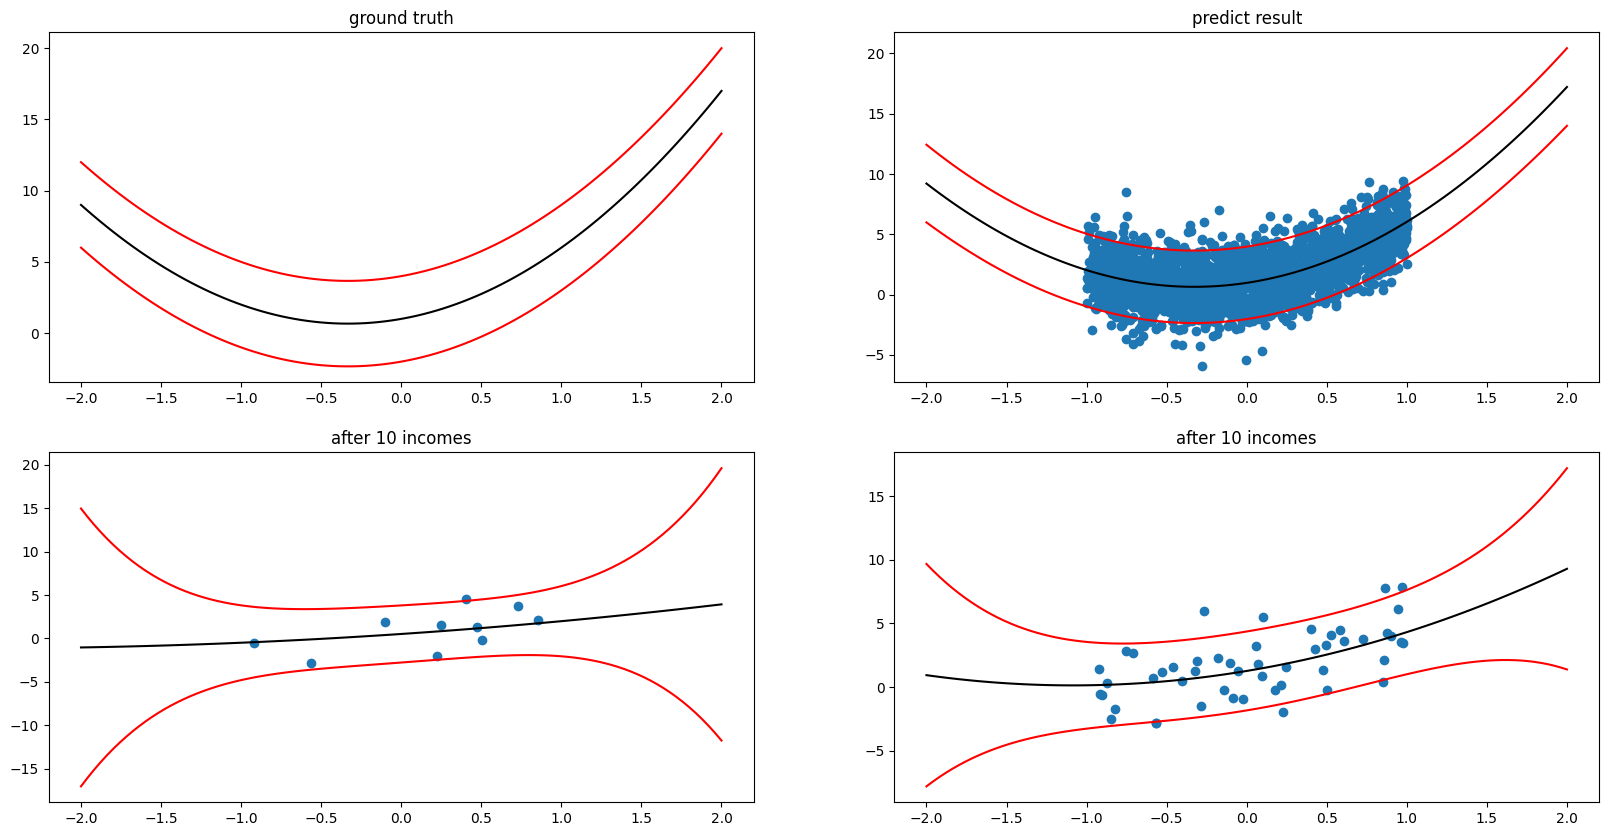

In [155]:
draw_picture(n,w,a, mu, var, tenth_mu, tenth_var, fiftenth_mu, fiftenth_var, np.array(data_collector))